In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# !pip install shap

### Import all required libraries and modules

In [88]:
import os 
import sys
import shap
from scipy.stats import shapiro, norm, mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sys.path.append("/Users/nikolaynechay/Iris-Species")
sys.path.append("/home/nikolay/Deloitte/project_task/Iris")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [89]:
from src.core.helpers.model_evaluation import evaluate_model
from src.core.helpers.error_analysis import analyse_logits_in_incorrect_predictions, create_detailed_analysis, calculate_main_statistics, analyse_contributions_in_incorrect_predictions, analyze_classification_errors_simple
from src.core.helpers.ea_hist_by_target import plot_error_distribution
from src.core.helpers.visualizations import plot_distribution_of_logits
from src.core.helpers.confusion_matrix_for_missclassifications import plot_confusion_matrix_for_miss_classifications

from src.core.helpers.calculate_boundaries import boundaries
from src.core.helpers.delete_outliers import delete_outliers
from src.core.helpers.feature_engineering import generate_top_features

In [90]:
# os.chdir("/Users/nikolaynechay/Iris-Species")

# Data Collection

### Setting required Global Variables

In [91]:
# IRIS_PATH="src/core/datafiles/raw/Iris.csv"
IRIS_PATH="/home/nikolay/Deloitte/project_task/Iris/src/core/datafiles/raw/Iris.csv"

### Load dataset

In [92]:
iris_df = pd.read_csv(IRIS_PATH)
iris_df.drop('Id', axis=1, inplace=True)  # Delete ID column
display(iris_df.head().style.background_gradient(cmap='Greys'))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5.000000,3.600000,1.400000,0.200000,Iris-setosa


# Baseline section

"Firstly, I'll analyze my data and build an initial baseline model. This model will serve as my starting point for quality comparison against all future iterations and decisions. This baseline quality threshold will determine the reasonableness and appropriateness of my future modeling decisions and improvements."

### Sampling train and test datasets

In [93]:
label_encoder = LabelEncoder()

X, y = iris_df.drop('Species', axis=1), iris_df['Species']
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=41,
    stratify=y
)

X.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Model building

"Baseline — a logistic regression model was built with L2 regularization to limit the magnitude of the coefficients and reduce overfitting. The model was optimized using the LBFGS algorithm, which is well-suited for small to medium-sized datasets. The training process was capped at 50 iterations."

In [94]:
baseline_model = LogisticRegression(max_iter=50, random_state=42)
baseline_model.fit(X_train, y_train)

baseline_train_df_with_predictions, baseline_train_accuracy, baseline_train_precision, baseline_train_recall, baseline_train_f1 = evaluate_model(X_train, y_train, baseline_model)
baseline_test_df_with_predictions, baseline_test_accuracy, baseline_test_precision, baseline_test_recall, baseline_test_f1 = evaluate_model(X_test, y_test, baseline_model)

print("Baseline model evaluation:")
print(f"Train Accuracy: {baseline_train_accuracy:.4f}")
print(f"Train Precision: {baseline_train_precision:.4f}")
print(f"Train Recall: {baseline_train_recall:.4f}")
print(f"Train F1: {baseline_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"Test Precision: {baseline_test_precision:.4f}")
print(f"Test Recall: {baseline_test_recall:.4f}")
print(f"Test F1: {baseline_test_f1:.4f}")

Baseline model evaluation:
Train Accuracy: 0.9750
Train Precision: 0.9752
Train Recall: 0.9750
Train F1: 0.9750
---------------------
Test Accuracy: 0.9333
Test Precision: 0.9333
Test Recall: 0.9333
Test F1: 0.9333


/home/nikolay/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Error Analysis

##### Distribution of correct and incorrect predictions on train set

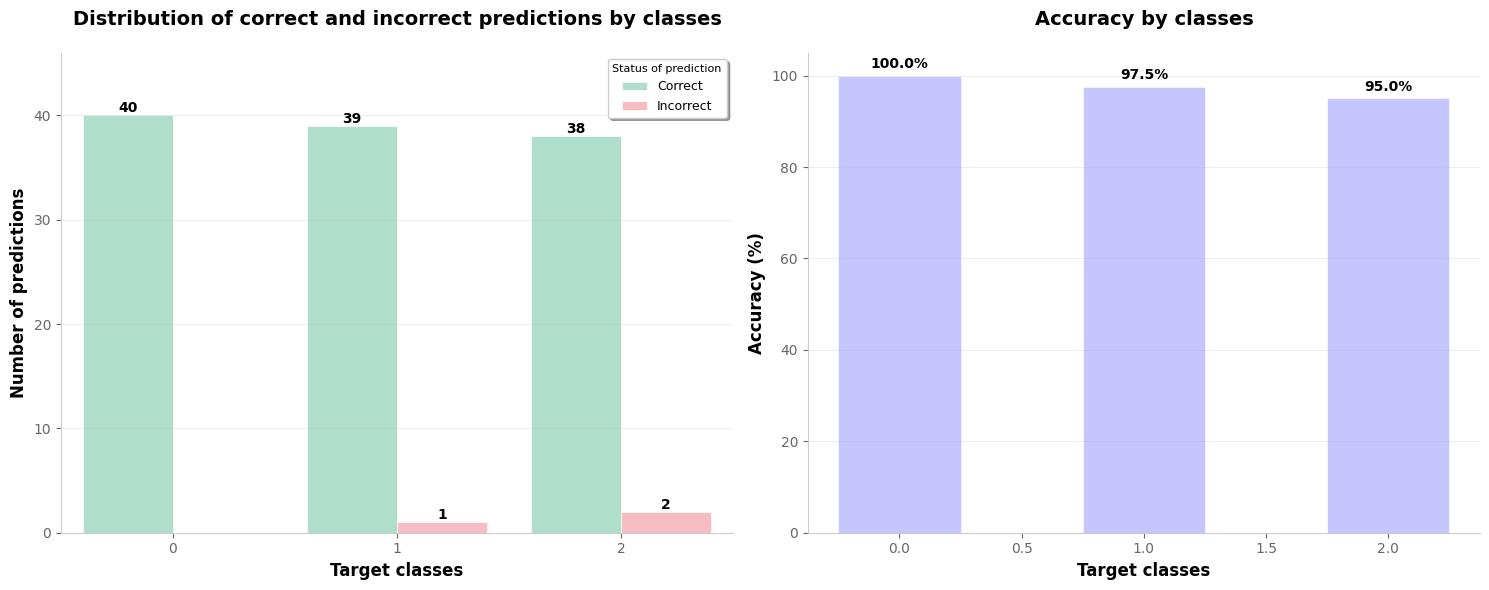

In [95]:
plot_error_distribution(baseline_train_df_with_predictions['predicted_label'], y_train)

##### Distribution of correct and incorrect predictions on test set

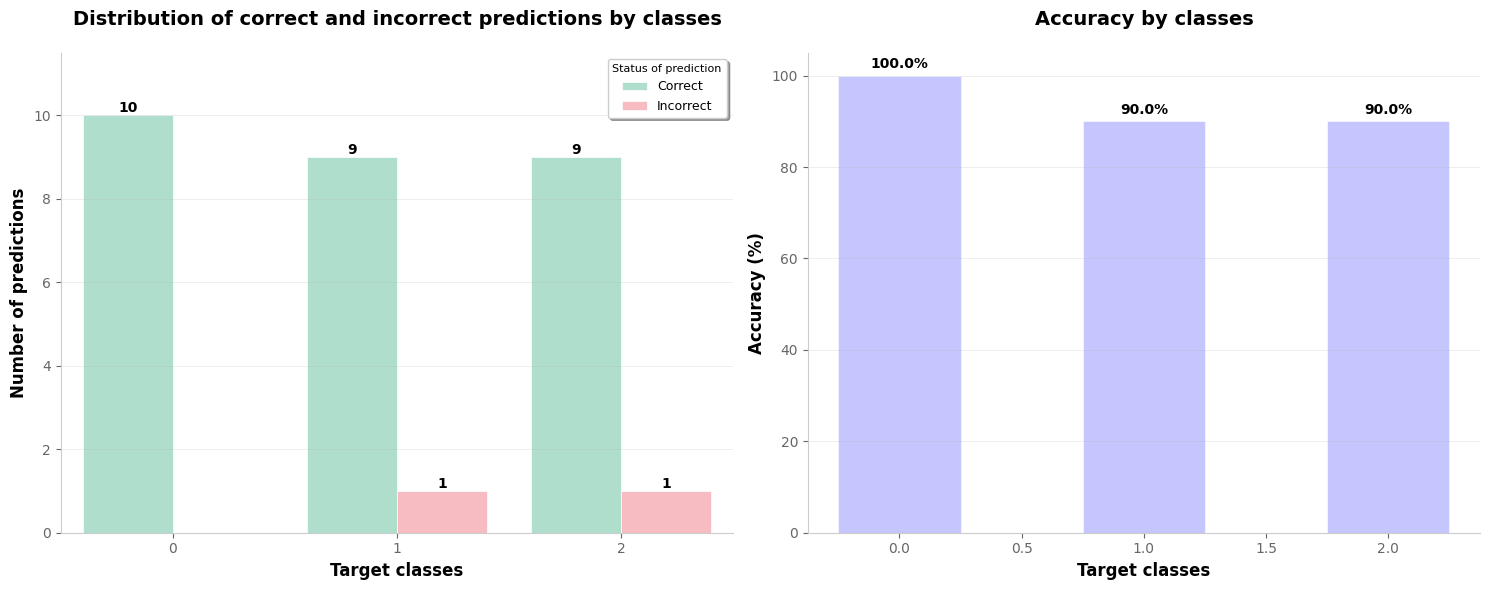

In [96]:
plot_error_distribution(baseline_test_df_with_predictions['predicted_label'], y_test)

##### Create dataframe for error classifications on train set

In [123]:
baseline_train_df_errors = baseline_train_df_with_predictions[baseline_train_df_with_predictions['is_correct'] == False]
baseline_train_df_errors.iloc[:]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
106,4.9,2.5,4.5,1.7,2,1,0.004,0.562,0.434,False
83,6.0,2.7,5.1,1.6,1,2,0.001,0.420,0.579,False
119,6.0,2.2,5.0,1.5,2,1,0.001,0.600,0.399,False


##### Create dataframe for error classifications on test set

In [ ]:
baseline_test_df_errors = baseline_test_df_with_predictions[baseline_test_df_with_predictions['is_correct'] == False]
baseline_test_df_errors.iloc[:]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
70,5.9,3.2,4.8,1.8,1,2,0.004,0.412,0.584,False
133,6.3,2.8,5.1,1.5,2,1,0.001,0.542,0.456,False


##### Plot confusion matrix for miss classifications on train set

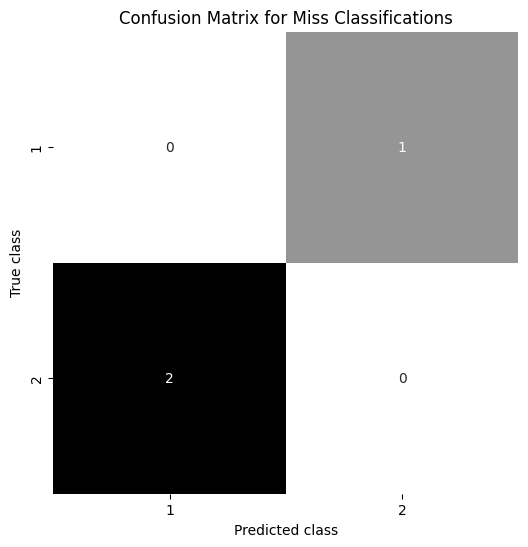

In [99]:
plot_confusion_matrix_for_miss_classifications(baseline_train_df_errors)

##### Plot confusion matrix for miss classifications on test set

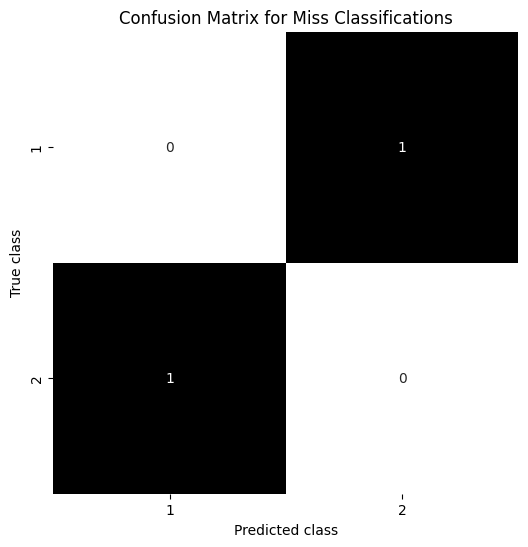

In [100]:
plot_confusion_matrix_for_miss_classifications(baseline_test_df_errors)

##### Extract weights and bias

In [101]:
baseline_weights = baseline_model.coef_
baseline_bias = baseline_model.intercept_
baseline_feature_names = X_train.columns.tolist()

print(f"Baseline\nWeights: {baseline_weights}\nBias: {baseline_bias}")

Baseline
Weights: [[ 0.21367371  0.77728805 -2.45584691 -1.01756082]
 [ 0.25086047 -0.53925165 -0.11524461 -1.02615973]
 [-0.46453417 -0.2380364   2.57109153  2.04372055]]
Bias: [  6.63242277   4.0906008  -10.72302357]


##### Create detailed analysis dataframe by baseline model 

In [102]:
baseline_train_detailed_df = create_detailed_analysis(baseline_train_df_with_predictions, baseline_weights, baseline_bias, baseline_feature_names)
baseline_test_detailed_df = create_detailed_analysis(baseline_test_df_with_predictions, baseline_weights, baseline_bias, baseline_feature_names)
baseline_train_detailed_df.head()

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,bias_diff
0,123,2,2,-3.788,0.002,6.632,1.803,0.454,4.091,1.985,0.544,-10.723,6.3,1.346,0.214,1.580,0.251,-2.927,-0.465,2.7,2.099,0.777,-1.456,-0.539,-0.643,-0.238,4.9,-12.034,-2.456,-0.565,-0.115,12.598,2.571,1.8,-1.832,-1.018,-1.847,-1.026,3.679,2.044,NaN,NaN,NaN,NaN,NaN
1,106,2,1,-3.159,0.004,6.632,1.709,0.562,4.091,1.450,0.434,-10.723,4.9,1.047,0.214,1.229,0.251,-2.276,-0.465,2.5,1.943,0.777,-1.348,-0.539,-0.595,-0.238,4.5,-11.051,-2.456,-0.519,-0.115,11.570,2.571,1.7,-1.730,-1.018,-1.744,-1.026,3.474,2.044,3.505,-0.753,-12.089,-5.219,14.814
2,149,2,2,-4.131,0.001,6.632,1.518,0.250,4.091,2.613,0.749,-10.723,5.9,1.261,0.214,1.480,0.251,-2.741,-0.465,3.0,2.332,0.777,-1.618,-0.539,-0.714,-0.238,5.1,-12.525,-2.456,-0.588,-0.115,13.113,2.571,1.8,-1.832,-1.018,-1.847,-1.026,3.679,2.044,NaN,NaN,NaN,NaN,NaN
3,10,0,0,6.775,0.976,6.632,3.072,0.024,4.091,-9.847,0.000,-10.723,5.4,1.154,0.214,1.355,0.251,-2.508,-0.465,3.7,2.876,0.777,-1.995,-0.539,-0.881,-0.238,1.5,-3.684,-2.456,-0.173,-0.115,3.857,2.571,0.2,-0.204,-1.018,-0.205,-1.026,0.409,2.044,NaN,NaN,NaN,NaN,NaN
4,98,1,1,1.179,0.203,6.632,2.547,0.796,4.091,-3.726,0.002,-10.723,5.1,1.090,0.214,1.279,0.251,-2.369,-0.465,2.5,1.943,0.777,-1.348,-0.539,-0.595,-0.238,3.0,-7.368,-2.456,-0.346,-0.115,7.713,2.571,1.1,-1.119,-1.018,-1.129,-1.026,2.248,2.044,NaN,NaN,NaN,NaN,NaN


##### Dataframe with missclassifications on train set

In [103]:
baseline_train_error_df = baseline_train_detailed_df[baseline_train_detailed_df['true_label'] != baseline_train_detailed_df['predicted_label']]
print(list(baseline_train_error_df.columns))
print(baseline_train_error_df.shape)
baseline_train_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,bias_diff
1,106,2,1,-3.159,0.004,6.632,1.709,0.562,4.091,1.450,0.434,-10.723,4.9,1.047,0.214,1.229,0.251,-2.276,-0.465,2.5,1.943,0.777,-1.348,-0.539,-0.595,-0.238,4.5,-11.051,-2.456,-0.519,-0.115,11.570,2.571,1.7,-1.730,-1.018,-1.744,-1.026,3.474,2.044,3.505,-0.753,-12.089,-5.219,14.814
10,83,1,2,-4.140,0.001,6.632,1.910,0.420,4.091,2.230,0.579,-10.723,6.0,1.282,0.214,1.505,0.251,-2.787,-0.465,2.7,2.099,0.777,-1.456,-0.539,-0.643,-0.238,5.1,-12.525,-2.456,-0.588,-0.115,13.113,2.571,1.6,-1.628,-1.018,-1.642,-1.026,3.270,2.044,-4.292,0.813,13.700,4.912,-14.814
113,119,2,1,-4.181,0.001,6.632,2.294,0.600,4.091,1.887,0.399,-10.723,6.0,1.282,0.214,1.505,0.251,-2.787,-0.465,2.2,1.710,0.777,-1.186,-0.539,-0.524,-0.238,5.0,-12.279,-2.456,-0.576,-0.115,12.855,2.571,1.5,-1.526,-1.018,-1.539,-1.026,3.066,2.044,4.292,-0.663,-13.432,-4.605,14.814


##### Dataframe with missclassifications on test set

In [104]:
baseline_test_error_df = baseline_test_detailed_df[baseline_test_detailed_df['true_label'] != baseline_test_detailed_df['predicted_label']]
print(list(baseline_test_error_df.columns))
print(baseline_test_error_df.shape)
baseline_test_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,bias_diff
7,70,1,2,-3.239,0.004,6.632,1.445,0.412,4.091,1.794,0.584,-10.723,5.9,1.261,0.214,1.48,0.251,-2.741,-0.465,3.2,2.487,0.777,-1.726,-0.539,-0.762,-0.238,4.8,-11.788,-2.456,-0.553,-0.115,12.341,2.571,1.8,-1.832,-1.018,-1.847,-1.026,3.679,2.044,-4.221,0.964,12.894,5.526,-14.814
19,133,2,1,-3.896,0.001,6.632,2.034,0.542,4.091,1.862,0.456,-10.723,6.3,1.346,0.214,1.58,0.251,-2.927,-0.465,2.8,2.176,0.777,-1.510,-0.539,-0.667,-0.238,5.1,-12.525,-2.456,-0.588,-0.115,13.113,2.571,1.5,-1.526,-1.018,-1.539,-1.026,3.066,2.044,4.507,-0.843,-13.700,-4.605,14.814


##### Train error analysis 

In [105]:
results = analyze_classification_errors_simple(
    df=baseline_train_error_df,
    feature_names=X_train.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 106.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.50, contribution=-12.089 
  PetalWidthCm   : value=1.70, contribution=-5.219 
  SepalLengthCm  : value=4.90, contribution=3.505 
  SepalWidthCm   : value=2.50, contribution=-0.753 
Main impact: PetalLengthCm (contribution: -12.089)

ERROR #2 (ID: 83.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=13.700 
  PetalWidthCm   : value=1.60, contribution=4.912 
  SepalLengthCm  : value=6.00, contribution=-4.292 
  SepalWidthCm   : value=2.70, contribution=0.813 
Main impact: PetalLengthCm (contribution: 13.700)

ERROR #3 (ID: 119.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.00, contribution=-13.432 
  PetalWidthCm   : value=1.50, contribution=-4.605 
  SepalLengthCm  : value=6.00, 

##### Test error analysis 

In [106]:
results = analyze_classification_errors_simple(
    df=baseline_test_error_df,
    feature_names=X_test.columns.tolist()
)

Analyse classification errors
Number of errors: 2

ERROR #1 (ID: 70.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.80, contribution=12.894 
  PetalWidthCm   : value=1.80, contribution=5.526 
  SepalLengthCm  : value=5.90, contribution=-4.221 
  SepalWidthCm   : value=3.20, contribution=0.964 
Main impact: PetalLengthCm (contribution: 12.894)

ERROR #2 (ID: 133.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=-13.700 
  PetalWidthCm   : value=1.50, contribution=-4.605 
  SepalLengthCm  : value=6.30, contribution=4.507 
  SepalWidthCm   : value=2.80, contribution=-0.843 
Main impact: PetalLengthCm (contribution: -13.700)


SUMMARY TABLE OF ERRORS:
----------------------------------------------------------------------
Error    ID    True       Predicted     Main impact     Contribution
---------------------------------------------------------------------

# Working section

"Section for experiments and testing of more accurate solutions based on the error analysis made by baseline model."

### Feature Engineering 

During the error analysis of the baseline model, it became evident that in all cases of misclassification, the model assigned the highest weight to the `PetalLengthCm` feature. Additionally, the model needs to be robust to "mutant" inputs — atypical feature values.

As a result, a feature engineering step was introduced to create new features aimed at improving the model’s robustness, including its ability to handle such mutants. To achieve this, new features were generated based on pairwise ratios of the original features. From this extended set, the most informative features in terms of class separability were selected. Finally, the top_k most impactful features were chosen to train the same linear model.


In [107]:
new_df = generate_top_features(iris_df, target_column='Species', k=3)
new_df.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,SepalWidthCm/PetalLengthCm,Species
0,1.4,3.642857,2.500000,Iris-setosa
1,1.4,3.500000,2.142857,Iris-setosa
2,1.3,3.615385,2.461538,Iris-setosa
3,1.5,3.066667,2.066667,Iris-setosa
4,1.4,3.571429,2.571429,Iris-setosa


### Sampling train and test datasets

In [108]:
X_new, y_new = new_df.drop('Species', axis=1), new_df['Species']
y_new = label_encoder.fit_transform(y_new)


X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X_new,y_new,
    test_size=0.2,
    random_state=41,
    stratify=y_new
)
X_new.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,SepalWidthCm/PetalLengthCm
0,1.4,3.642857,2.500000
1,1.4,3.500000,2.142857
2,1.3,3.615385,2.461538
3,1.5,3.066667,2.066667
4,1.4,3.571429,2.571429


### Model building

"Current working model is a logistic regression model was built with L2 regularization to limit the magnitude of the coefficients and reduce overfitting. The model was optimized using the LBFGS algorithm."

In [109]:
working_model = LogisticRegression(max_iter=50, random_state=41)
working_model.fit(X_new_train, y_new_train)

working_train_df_with_predictions, working_train_accuracy, working_train_precision, working_train_recall, working_train_f1 = evaluate_model(X_new_train, y_new_train, working_model)
working_test_df_with_predictions, working_test_accuracy, working_test_precision, working_test_recall, working_test_f1 = evaluate_model(X_new_test, y_new_test, working_model)

print("Working model evaluation:")
print(f"Train Accuracy: {working_train_accuracy:.4f}")
print(f"Train Precision: {working_train_precision:.4f}")
print(f"Train Recall: {working_train_recall:.4f}")
print(f"Train F1: {working_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {working_test_accuracy:.4f}")
print(f"Test Precision: {working_test_precision:.4f}")
print(f"Test Recall: {working_test_recall:.4f}")
print(f"Test F1: {working_test_f1:.4f}")

Working model evaluation:
Train Accuracy: 0.9500
Train Precision: 0.9500
Train Recall: 0.9500
Train F1: 0.9500
---------------------
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


In [110]:
working_train_df_with_predictions.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,SepalWidthCm/PetalLengthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
123,4.9,1.285714,0.551020,2,2,0.003,0.490,0.506,True
106,4.5,1.088889,0.555556,2,1,0.006,0.773,0.221,False
149,5.1,1.156863,0.588235,2,2,0.002,0.302,0.697,True
10,1.5,3.600000,2.466667,0,0,0.993,0.007,0.000,True
98,3.0,1.700000,0.833333,1,1,0.107,0.892,0.001,True


### Error Analysis

##### Distribution of correct and incorrect predictions on train set

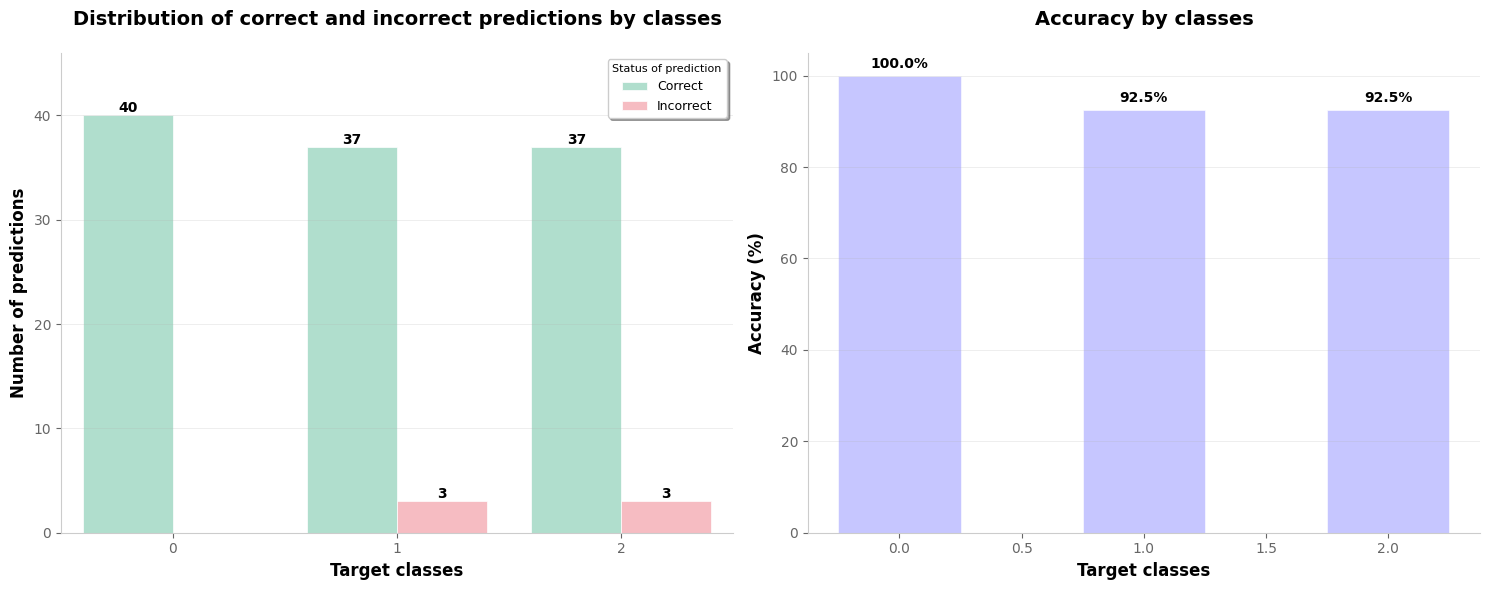

In [111]:
plot_error_distribution(working_train_df_with_predictions['predicted_label'], y_new_train)


##### Distribution of correct and incorrect predictions on test set

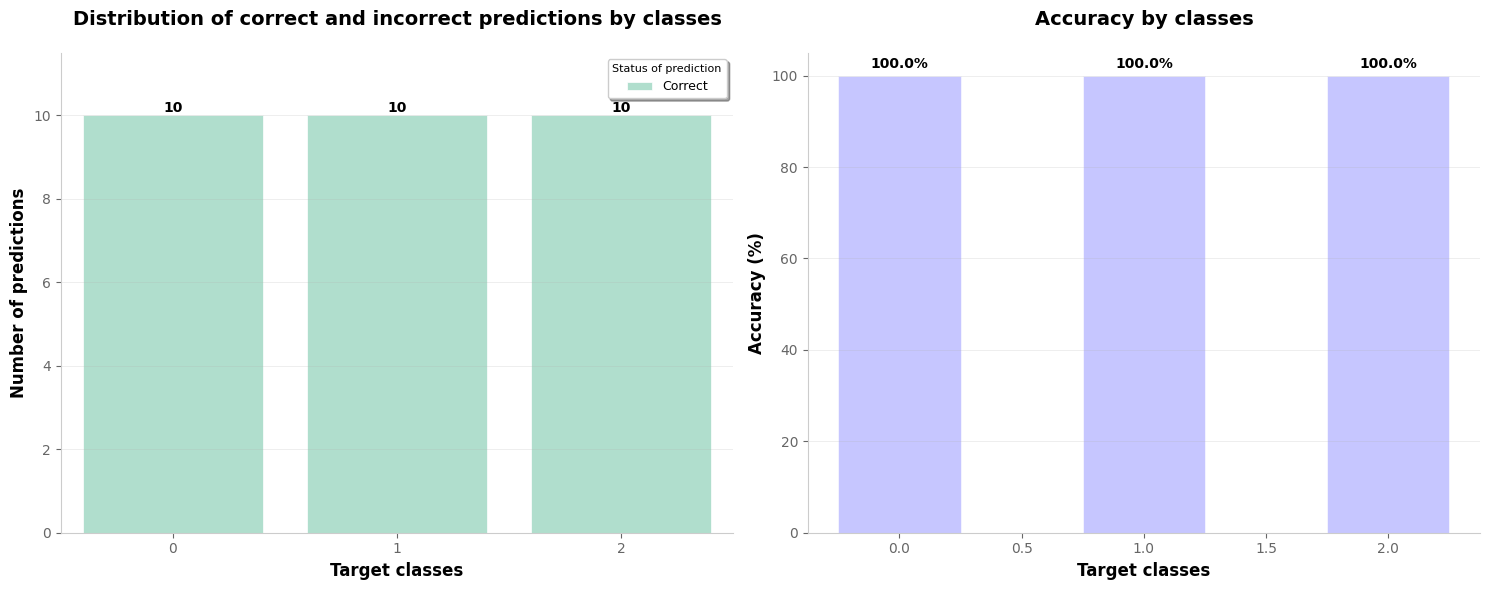

In [112]:
plot_error_distribution(working_test_df_with_predictions['predicted_label'], y_new_test)

##### Create dataframe for error classifications on train set

In [113]:
working_train_df_errors = working_train_df_with_predictions[working_train_df_with_predictions['is_correct'] == False]
working_train_df_errors.iloc[:]

,PetalLengthCm,SepalLengthCm/PetalLengthCm,SepalWidthCm/PetalLengthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
106,4.5,1.088889,0.555556,2,1,0.006,0.773,0.221,False
126,4.8,1.291667,0.583333,2,1,0.005,0.577,0.419,False
83,5.1,1.176471,0.529412,1,2,0.001,0.307,0.691,False
138,4.8,1.250000,0.625000,2,1,0.005,0.568,0.428,False
77,5.0,1.340000,0.600000,1,2,0.003,0.409,0.587,False
72,4.9,1.285714,0.510204,1,2,0.003,0.492,0.504,False


##### Create dataframe for error classifications on test set

In [114]:
working_test_df_errors = working_test_df_with_predictions[working_test_df_with_predictions['is_correct'] == False]
working_test_df_errors.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,SepalWidthCm/PetalLengthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct


##### Plot confusion matrix for miss classifications on train set

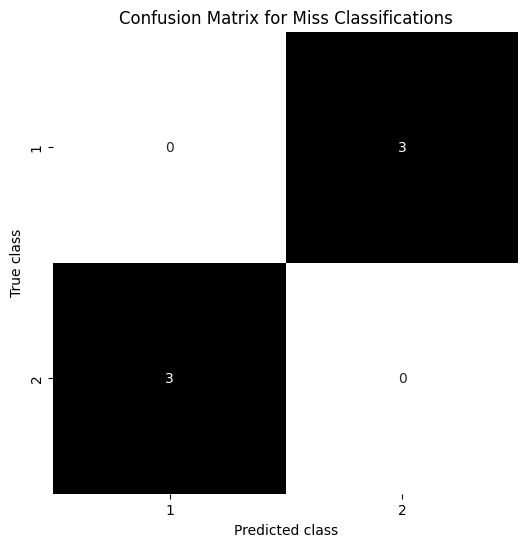

In [115]:
plot_confusion_matrix_for_miss_classifications(working_train_df_errors)

##### Plot confusion matrix for miss classifications on test set

In [116]:
plot_confusion_matrix_for_miss_classifications(working_test_df_errors)

No miss-classifications to display.


##### Extract weights and bias

In [117]:
working_weights = working_model.coef_
working_bias = working_model.intercept_
working_feature_names = X_new_train.columns.tolist()

print(f"Working\nWeights: {working_weights}\nBias: {working_bias}")

Working
Weights: [[-1.78920991  1.23297667  1.08545213]
 [-0.88023824 -0.27823038 -0.64790015]
 [ 2.66944816 -0.9547463  -0.43755198]]
Bias: [ 3.26185153  6.6726064  -9.93445793]


##### Create detailed analysis dataframe by working model 

In [118]:
working_train_detailed_df = create_detailed_analysis(working_train_df_with_predictions, working_weights, working_bias, working_feature_names)
working_test_detailed_df = create_detailed_analysis(working_test_df_with_predictions, working_weights, working_bias, working_feature_names)
working_train_detailed_df.head()

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,SepalLengthCm/PetalLengthCm_value,SepalLengthCm/PetalLengthCm_contribution_class_0,SepalLengthCm/PetalLengthCm_weight_class_0,SepalLengthCm/PetalLengthCm_contribution_class_1,SepalLengthCm/PetalLengthCm_weight_class_1,SepalLengthCm/PetalLengthCm_contribution_class_2,SepalLengthCm/PetalLengthCm_weight_class_2,SepalWidthCm/PetalLengthCm_value,SepalWidthCm/PetalLengthCm_contribution_class_0,SepalWidthCm/PetalLengthCm_weight_class_0,SepalWidthCm/PetalLengthCm_contribution_class_1,SepalWidthCm/PetalLengthCm_weight_class_1,SepalWidthCm/PetalLengthCm_contribution_class_2,SepalWidthCm/PetalLengthCm_weight_class_2,contribution_diff_PetalLengthCm,contribution_diff_SepalLengthCm/PetalLengthCm,contribution_diff_SepalWidthCm/PetalLengthCm,bias_diff
0,123,2,2,-3.322,0.003,3.262,1.645,0.490,6.673,1.677,0.506,-9.934,4.9,-8.767,-1.789,-4.313,-0.88,13.080,2.669,1.286,1.585,1.233,-0.358,-0.278,-1.228,-0.955,0.551,0.598,1.085,-0.357,-0.648,-0.241,-0.438,NaN,NaN,NaN,NaN
1,106,2,1,-2.844,0.006,3.262,2.049,0.773,6.673,0.795,0.221,-9.934,4.5,-8.051,-1.789,-3.961,-0.88,12.013,2.669,1.089,1.343,1.233,-0.303,-0.278,-1.040,-0.955,0.556,0.603,1.085,-0.360,-0.648,-0.243,-0.438,-15.974,0.737,-0.117,16.607
2,149,2,2,-3.798,0.002,3.262,1.480,0.302,6.673,2.318,0.697,-9.934,5.1,-9.125,-1.789,-4.489,-0.88,13.614,2.669,1.157,1.426,1.233,-0.322,-0.278,-1.105,-0.955,0.588,0.639,1.085,-0.381,-0.648,-0.257,-0.438,NaN,NaN,NaN,NaN
3,10,0,0,7.694,0.993,3.262,2.752,0.007,6.673,-10.447,0.000,-9.934,1.5,-2.684,-1.789,-1.320,-0.88,4.004,2.669,3.600,4.439,1.233,-1.002,-0.278,-3.437,-0.955,2.467,2.677,1.085,-1.598,-0.648,-1.079,-0.438,NaN,NaN,NaN,NaN
4,98,1,1,0.895,0.107,3.262,3.019,0.892,6.673,-3.914,0.001,-9.934,3.0,-5.368,-1.789,-2.641,-0.88,8.008,2.669,1.700,2.096,1.233,-0.473,-0.278,-1.623,-0.955,0.833,0.905,1.085,-0.540,-0.648,-0.365,-0.438,NaN,NaN,NaN,NaN


##### Dataframe with missclassifications on train set

In [119]:
working_train_error_df = working_train_detailed_df[working_train_detailed_df['true_label'] != working_train_detailed_df['predicted_label']]
print(list(working_train_error_df.columns))
print(working_train_error_df.shape)
working_train_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'SepalLengthCm/PetalLengthCm_value', 'SepalLengthCm/PetalLengthCm_contribution_class_0', 'SepalLengthCm/PetalLengthCm_weight_class_0', 'SepalLengthCm/PetalLengthCm_contribution_class_1', 'SepalLengthCm/PetalLengthCm_weight_class_1', 'SepalLengthCm/PetalLengthCm_contribution_class_2', 'SepalLengthCm/PetalLengthCm_weight_class_2', 'SepalWidthCm/PetalLengthCm_value', 'SepalWidthCm/PetalLengthCm_contribution_class_0', 'SepalWidthCm/PetalLengthCm_weight_class_0', 'SepalWidthCm/PetalLengthCm_contribution_class_1', 'SepalWidthCm/PetalLengthCm_weight_

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,SepalLengthCm/PetalLengthCm_value,SepalLengthCm/PetalLengthCm_contribution_class_0,SepalLengthCm/PetalLengthCm_weight_class_0,SepalLengthCm/PetalLengthCm_contribution_class_1,SepalLengthCm/PetalLengthCm_weight_class_1,SepalLengthCm/PetalLengthCm_contribution_class_2,SepalLengthCm/PetalLengthCm_weight_class_2,SepalWidthCm/PetalLengthCm_value,SepalWidthCm/PetalLengthCm_contribution_class_0,SepalWidthCm/PetalLengthCm_weight_class_0,SepalWidthCm/PetalLengthCm_contribution_class_1,SepalWidthCm/PetalLengthCm_weight_class_1,SepalWidthCm/PetalLengthCm_contribution_class_2,SepalWidthCm/PetalLengthCm_weight_class_2,contribution_diff_PetalLengthCm,contribution_diff_SepalLengthCm/PetalLengthCm,contribution_diff_SepalWidthCm/PetalLengthCm,bias_diff
1,106,2,1,-2.844,0.006,3.262,2.049,0.773,6.673,0.795,0.221,-9.934,4.5,-8.051,-1.789,-3.961,-0.88,12.013,2.669,1.089,1.343,1.233,-0.303,-0.278,-1.040,-0.955,0.556,0.603,1.085,-0.360,-0.648,-0.243,-0.438,-15.974,0.737,-0.117,16.607
5,126,2,1,-3.101,0.005,3.262,1.710,0.577,6.673,1.390,0.419,-9.934,4.8,-8.588,-1.789,-4.225,-0.88,12.813,2.669,1.292,1.593,1.233,-0.359,-0.278,-1.233,-0.955,0.583,0.633,1.085,-0.378,-0.648,-0.255,-0.438,-17.038,0.874,-0.123,16.607
10,83,1,2,-3.838,0.001,3.262,1.513,0.307,6.673,2.325,0.691,-9.934,5.1,-9.125,-1.789,-4.489,-0.88,13.614,2.669,1.176,1.451,1.233,-0.327,-0.278,-1.123,-0.955,0.529,0.575,1.085,-0.343,-0.648,-0.232,-0.438,18.103,-0.796,0.111,-16.607
21,138,2,1,-3.107,0.005,3.262,1.695,0.568,6.673,1.412,0.428,-9.934,4.8,-8.588,-1.789,-4.225,-0.88,12.813,2.669,1.250,1.541,1.233,-0.348,-0.278,-1.193,-0.955,0.625,0.678,1.085,-0.405,-0.648,-0.273,-0.438,-17.038,0.846,-0.131,16.607
29,77,1,2,-3.381,0.003,3.262,1.510,0.409,6.673,1.871,0.587,-9.934,5.0,-8.946,-1.789,-4.401,-0.88,13.347,2.669,1.340,1.652,1.233,-0.373,-0.278,-1.279,-0.955,0.600,0.651,1.085,-0.389,-0.648,-0.263,-0.438,17.748,-0.907,0.126,-16.607
108,72,1,2,-3.366,0.003,3.262,1.671,0.492,6.673,1.695,0.504,-9.934,4.9,-8.767,-1.789,-4.313,-0.88,13.080,2.669,1.286,1.585,1.233,-0.358,-0.278,-1.228,-0.955,0.510,0.554,1.085,-0.331,-0.648,-0.223,-0.438,17.393,-0.870,0.107,-16.607


##### Dataframe with missclassifications on test set

In [120]:
working_test_error_df = working_test_detailed_df[working_test_detailed_df['true_label'] != working_test_detailed_df['predicted_label']]
print(list(working_test_error_df.columns))
print(working_test_error_df.shape)
working_test_error_df.head()

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'SepalLengthCm/PetalLengthCm_value', 'SepalLengthCm/PetalLengthCm_contribution_class_0', 'SepalLengthCm/PetalLengthCm_weight_class_0', 'SepalLengthCm/PetalLengthCm_contribution_class_1', 'SepalLengthCm/PetalLengthCm_weight_class_1', 'SepalLengthCm/PetalLengthCm_contribution_class_2', 'SepalLengthCm/PetalLengthCm_weight_class_2', 'SepalWidthCm/PetalLengthCm_value', 'SepalWidthCm/PetalLengthCm_contribution_class_0', 'SepalWidthCm/PetalLengthCm_weight_class_0', 'SepalWidthCm/PetalLengthCm_contribution_class_1', 'SepalWidthCm/PetalLengthCm_weight_

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,SepalLengthCm/PetalLengthCm_value,SepalLengthCm/PetalLengthCm_contribution_class_0,SepalLengthCm/PetalLengthCm_weight_class_0,SepalLengthCm/PetalLengthCm_contribution_class_1,SepalLengthCm/PetalLengthCm_weight_class_1,SepalLengthCm/PetalLengthCm_contribution_class_2,SepalLengthCm/PetalLengthCm_weight_class_2,SepalWidthCm/PetalLengthCm_value,SepalWidthCm/PetalLengthCm_contribution_class_0,SepalWidthCm/PetalLengthCm_weight_class_0,SepalWidthCm/PetalLengthCm_contribution_class_1,SepalWidthCm/PetalLengthCm_weight_class_1,SepalWidthCm/PetalLengthCm_contribution_class_2,SepalWidthCm/PetalLengthCm_weight_class_2


##### Train error analysis

In [121]:
results = analyze_classification_errors_simple(
    df=working_train_error_df,
    feature_names=X_new.columns.tolist()
)

Analyse classification errors
Number of errors: 6

ERROR #1 (ID: 106.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.50, contribution=-15.974 
  SepalLengthCm/PetalLengthCm: value=1.09, contribution=0.737 
  SepalWidthCm/PetalLengthCm: value=0.56, contribution=-0.117 
Main impact: PetalLengthCm (contribution: -15.974)

ERROR #2 (ID: 126.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.80, contribution=-17.038 
  SepalLengthCm/PetalLengthCm: value=1.29, contribution=0.874 
  SepalWidthCm/PetalLengthCm: value=0.58, contribution=-0.123 
Main impact: PetalLengthCm (contribution: -17.038)

ERROR #3 (ID: 83.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=18.103 
  SepalLengthCm/PetalLengthCm: value=1.18, contribution=-0.796 
  SepalWidthCm/PetalLengthCm: value=0.53, contribution=0.111 
Main impact: 

##### Test error analysis

In [122]:
results = analyze_classification_errors_simple(
    df=working_test_error_df,
    feature_names=X_new.columns.tolist()
)

Analyse classification errors
Number of errors: 0


SUMMARY TABLE OF ERRORS:
----------------------------------------------------------------------
Error    ID    True       Predicted     Main impact     Contribution
----------------------------------------------------------------------
----------------------------------------------------------------------
